# Simpson's Paradox (Section 4.2)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linear_regression import LinearRegression

# force reimport linear regression
import importlib
import linear_regression
importlib.reload(linear_regression)
from linear_regression import LinearRegression
import algorithms

## Data Generation

In [64]:
np.random.seed(0)

total_observations = 1010
num_observations_pop_1 = 10 # A
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

# Generate X values.
mean_pop_1 = np.array([25])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0.25]])
vars_pop_2 = np.array([[0.25]])

x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:10]
x2 = x[10:]

x1_0 = [pt[0] for pt in x1]
x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x2_1 = [pt[1] for pt in x2]

# Generate Y values.
epsilon1 = np.random.normal(0, 1, num_observations_pop_1)
slope1 = -1
intercept1 = 40
y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope1*x1_1[i] + intercept1 + epsilon1[i])

epsilon2 = np.random.normal(0, 1, num_observations_pop_2)
slope2 = -1
intercept2 = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope2*x2_1[i] + intercept2 + epsilon2[i])

y = np.concatenate([y1, y2], axis=0)

## Model Fitting

Fit the data using OLS regression.

In [65]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 pop A: -0.4038376302670203
Estimated beta1 pop B: -0.9895109324018502


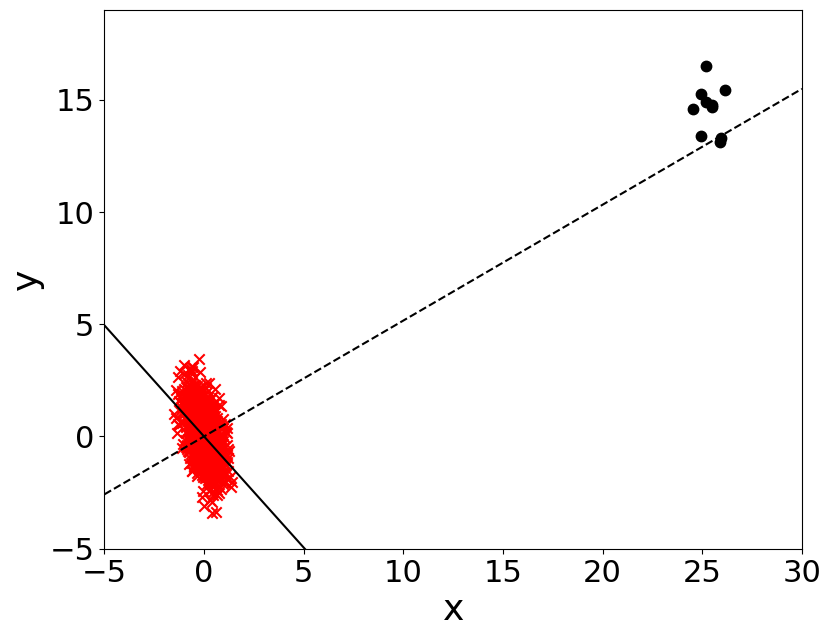

In [66]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-5, 30, 100)
y_values_full = lr.beta[1] * x_values
y_value_red_crosses = modified_lr.beta[1] * x_values
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.ylim(-5, 19)
plt.xlim(-5, 30)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
# plt.legend(fontsize=22)
# plt.savefig('simpsons_paradox_example_5.pdf')
plt.show()

## Net Approx. Algorithm

In [67]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy.linalg
import itertools

'''
For fixed lambda, compute maximum weight of any weight vector w
that has lambda in OLS(X,y,w)
'''
def solve_fixed_lambda(X,XR,lam):
    n = X.shape[0]
    d = X.shape[1]
    c = -np.ones((n))
    A_eq = np.zeros((d,n))
    b_eq = np.zeros((d))
    for i in range(d):
        A_eq[i] = (X.T)[i] * (XR@lam)
    m = gp.Model("net-model")
    m.Params.OutputFlag = 0
    w = m.addMVar(shape=n,vtype=GRB.CONTINUOUS,name="w",lb=0,ub=1)
    m.setObjective(c @ w, GRB.MINIMIZE)
    m.addConstr(A_eq @ w == b_eq)
    m.optimize()
    return w.X

'''
NET UPPER BOUND

Input:
- X: n x d (covariate matrix)
- y: n (response vector)
- trials: integer

Output:
- Net upper bound on Stability(X,y)
'''
def net_algorithm(X,y,trials):
    n = X.shape[0]
    d = X.shape[1]
    XR = np.zeros((d,n))
    for i in range(d-1):
        XR[i] = (X.T)[i+1]
    XR[d-1] = y
    XR = XR.T
    assert(np.linalg.matrix_rank(XR)==d)
    U,s,Vh = scipy.linalg.svd(XR, full_matrices=False)
    A = Vh.T @ np.diag(1.0/s) @ np.eye(d)
    wstar = np.zeros((n))
    for i in range(trials):
        v = np.random.multivariate_normal(np.zeros((d)),np.eye(d))
        v = v / np.linalg.norm(v)
        lam = A@v
        w = solve_fixed_lambda(X,XR,lam)
        if sum(w) > sum(wstar):
            wstar = w
    return n-sum(wstar), wstar

In [68]:
n_sumwstar, wstar = net_algorithm(x[:,1:],y,1000)

In [ ]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indice of wstar that are non-one.
mis_inds = np.where(wstar != 1)[0] # round down.
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 9.283296248363968


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Gurobi [FH23]

In [10]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01
set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 2020 rows, 1012 columns and 2020 nonzeros
Model fingerprint: 0x58227265
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-04, 3e+01]
  QLMatrix range   [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2020 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 20

In [13]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1013 columns and 1 nonzeros
Model fingerprint: 0x33619802
Model has 3 quadratic constraints
Variable types: 3 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-07, 7e+02]
  QLMatrix range   [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 1000 (0.01s)
Loaded user MIP start with objective 1000

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 6062 rows, 10103 columns, 23230 nonzeros
Presolved model has 6060 SOS constraint(s)
Variable types: 6063 

In [17]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Gurobi (no warm start)

In [24]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1013 columns and 1 nonzeros
Model fingerprint: 0x7fd37f7c
Model has 3 quadratic constraints
Variable types: 3 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-07, 7e+02]
  QLMatrix range   [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 6062 rows, 10103 columns, 23230 nonzeros
Presolved model has 6060 SOS constraint(s)
Variable types: 6063 continuous, 4040 integer (4040 binary)

Root relaxation: o

In [25]:
integer_weights = np.array([w.X for w in weights])

In [26]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   47,   48,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   71,   72,   73,   75,   76,   77,   78,   79,   80,   81,
         82,   83,   84,   86,   88,   89,   90,   91,   92,   94,   95,
         97,   98,   99,  100,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  125,  126,  127,  128,  129,  130,  132,  133,
        135,  136,  137,  139,  140,  141,  142,  143,  144,  145,  146,
        147,  148,  149,  150,  151,  152,  153,  154,  155,  156,  157,
        158,  159,  160,  161,  162,  163,  164,  1

#### Refit after Removing Flagged Points.

In [ ]:
Gurobi_inds = indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(122, 2)
(122,)


In [29]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by NetApprox: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 after removing subset specified by NetApprox: -1.0584009956942815


## Additive and Greedy algorithms.

In [16]:
def compute_scores(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

## Additive Algorithms.

In [17]:
simpsons_paradox_df = compute_scores(x, y, lr)
simpsons_paradox_df.head(10)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,25.882026,13.117643,-0.297040,0.100298,0.001150,0.001278,1,1,-0.012852,-0.014202
1,25.200079,16.473907,3.411045,0.095089,-0.012852,-0.014202,8,8,-0.008704,-0.009598
2,25.489369,14.672190,1.460081,0.097281,-0.005565,-0.006165,3,3,-0.007443,-0.008290
3,26.120447,15.442958,1.905272,0.102152,-0.007443,-0.008290,9,9,-0.006883,-0.007606
4,25.933779,13.275698,-0.165685,0.100699,0.000643,0.000715,5,5,-0.006865,-0.007544
5,24.511361,14.581339,1.873790,0.089970,-0.006865,-0.007544,6,6,-0.005883,-0.006517
6,25.475044,14.749208,1.544489,0.097172,-0.005883,-0.006517,2,2,-0.005565,-0.006165
7,24.924321,13.396990,0.476393,0.093022,-0.001775,-0.001957,7,7,-0.001775,-0.001957
8,24.948391,15.266575,2.333560,0.093202,-0.008704,-0.009598,907,907,-0.000159,-0.000159
9,25.205299,14.891920,1.826364,0.095128,-0.006883,-0.007606,260,260,-0.000158,-0.000158


In [18]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(simpsons_paradox_df["sorted_IF_scores"][:9]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is {round(lr.beta[1] + sum(simpsons_paradox_df["sorted_1Exact_scores"][:9]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 10 is {round((modified_lr.beta[1]), 4)}.')

The AMIP approximation of the refit is 0.4598.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is 0.4539.
The true change induced by dropping the worst-case subset of size at most 10 is -0.9895.


### The Leverage Algorithm.

In [8]:
# sort leverage scores in descending order.
np.argsort(simpsons_paradox_df['leverage'][:10])

0    5
1    7
2    8
3    1
4    9
5    6
6    2
7    0
8    4
9    3
Name: leverage, dtype: int64

In [9]:
print(f'The sum of the leverage scores of the 10 black dots is {round(sum(simpsons_paradox_df["leverage"][:10]), 4)}.')

The sum of the leverage scores of the 10 black dots is 0.964.


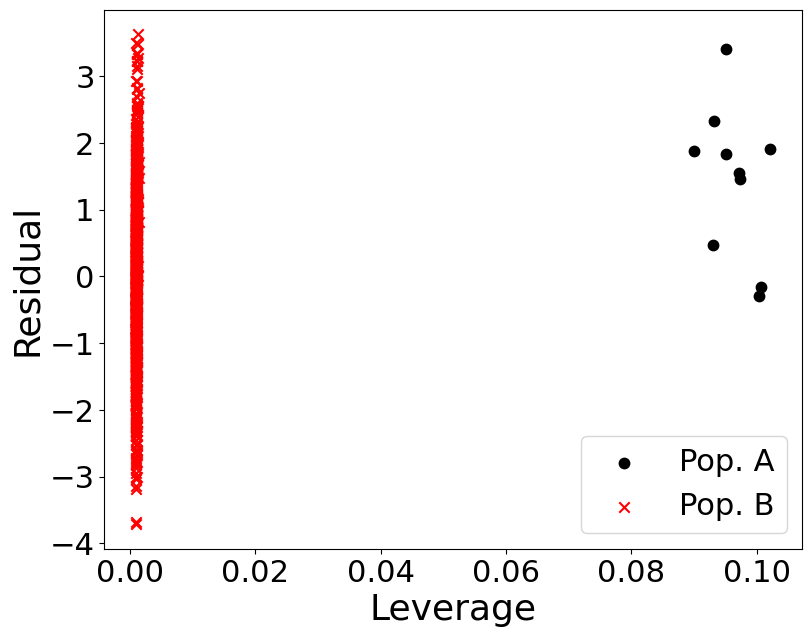

In [14]:
plt.figure(figsize=(9, 7))

plt.scatter(simpsons_paradox_df['leverage'][:10], simpsons_paradox_df['residual'][:10], marker='o', color='black', label='Pop. A', s=56)
plt.scatter(simpsons_paradox_df['leverage'][10:], simpsons_paradox_df['residual'][10:], marker='x', color='r', label='Pop. B', s=56)

plt.xlabel('Leverage', fontsize=26) 
plt.ylabel('Residual', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('simpsons_paradox_levresid.pdf', bbox_inches='tight')
plt.show()

## Greedy Algorithms.

In [46]:
def create_orig_df(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(9, 7))
    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='red', label='Pop. B') # pop B

    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9:
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(x, y, orig_if_inds, orig_newton_inds, lr, method='IF'):
    '''
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    '''
    ctr = 0
    prev_beta = lr.beta[1]
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    # Track the mapping from current indices to original indices
    current_indices = list(range(len(y)))

    for _ in range(11):
        print(f'iteration {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        index_to_remove = inds[0]
        # Record the original index being removed
        original_index = current_indices[index_to_remove]
        print("index to remove (original):", original_index)
        dropped_order.append(original_index)

        # Remove the data point
        x = np.delete(x, index_to_remove, axis=0)
        y = np.delete(y, index_to_remove, axis=0)
        current_indices.pop(index_to_remove)  # Update index map

        # Refit linear regression
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # Recompute scores and plot
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df)

        # Track beta changes
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy

In [47]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643 -0.297040  0.100298   0.001150  0.001278
1  25.200079  16.473907  3.411045  0.095089  -0.012852 -0.014202
2  25.489369  14.672190  1.460081  0.097281  -0.005565 -0.006165
3  26.120447  15.442958  1.905272  0.102152  -0.007443 -0.008290
4  25.933779  13.275698 -0.165685  0.100699   0.000643  0.000715
inds [  1   8   3   9   5   6   2   7 907 260]
newton_inds [  1   8   3   9   5   6   2   7 907 260]


iteration 0
index to remove (original): 1
fitted beta1: 0.5017041334413944
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  0.071080  0.110837  -0.000304 -0.000342
1  25.489369  14.672190  1.822625  0.107504  -0.007677 -0.008601
2  26.120447  15.442958  2.276778  0.112886  -0.009829 -0.011079
3  25.933779  13.275698  0.203170  0.111280  -0.000871 -0.000980
4  24.511361  14.581339  2.222444  0.099425  -0.008999 -0.009992
Point to Drop:  7


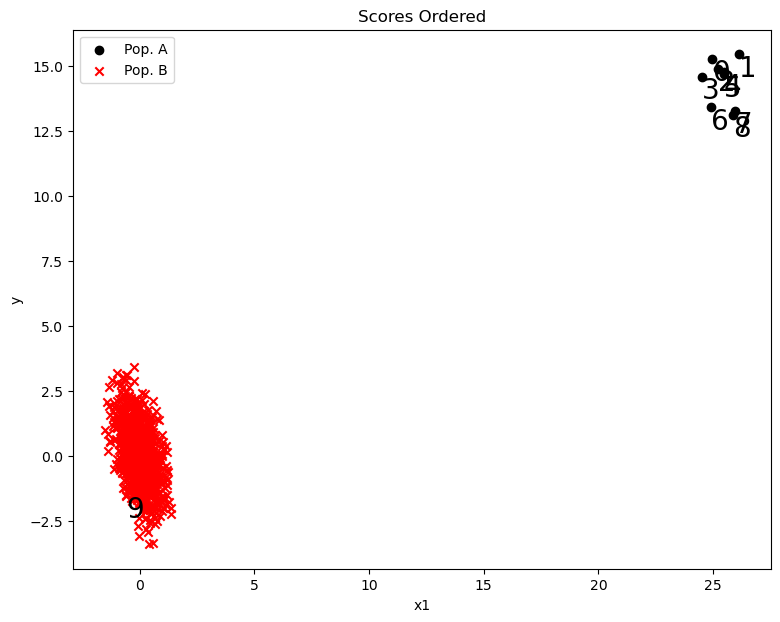

iteration 1
index to remove (original): 8
fitted beta1: 0.48935079165663814
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  0.391302  0.123563  -0.001866 -0.002129
1  25.489369  14.672190  2.137996  0.119847  -0.010039 -0.011406
2  26.120447  15.442958  2.599945  0.125847  -0.012512 -0.014313
3  25.933779  13.275698  0.524031  0.124057  -0.002504 -0.002858
4  24.511361  14.581339  2.525733  0.110841  -0.011401 -0.012822
Point to Drop:  2


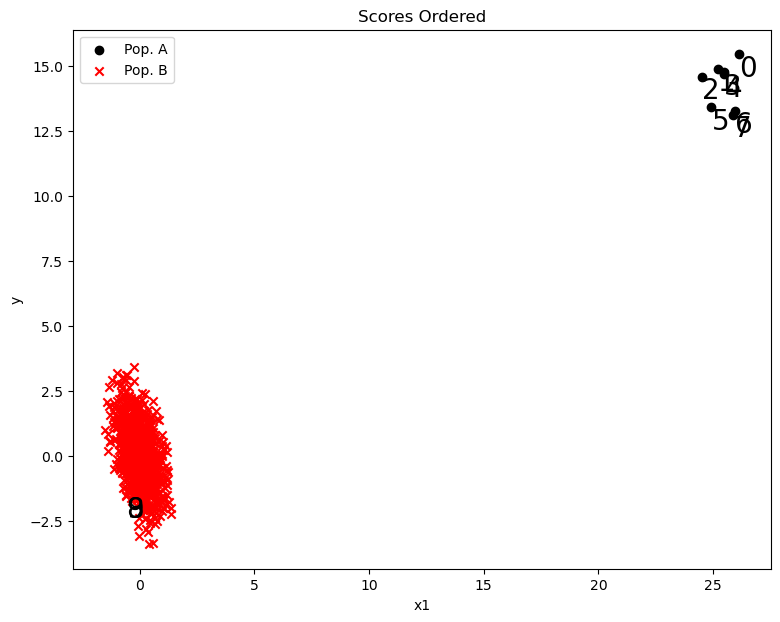

iteration 2
index to remove (original): 3
fitted beta1: 0.47503745815665105
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  0.762191  0.141352  -0.004158 -0.004842
1  25.489369  14.672190  2.503264  0.137101  -0.013446 -0.015583
2  25.933779  13.275698  0.895661  0.141917  -0.004895 -0.005705
3  24.511361  14.581339  2.877003  0.126797  -0.014857 -0.017015
4  25.475044  14.749208  2.587087  0.136947  -0.013889 -0.016092
Point to Drop:  6


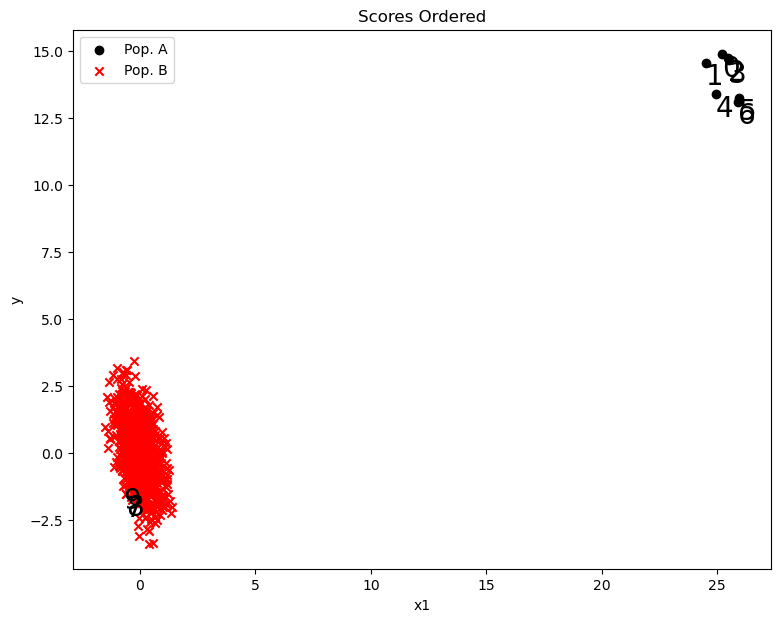

iteration 3
index to remove (original): 9
fitted beta1: 0.45750814988620736
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  1.216528  0.163236  -0.007663 -0.009158
1  25.489369  14.672190  2.950718  0.158327  -0.018303 -0.021746
2  25.933779  13.275698  1.350905  0.163889  -0.008527 -0.010198
3  24.511361  14.581339  3.307314  0.146428  -0.019724 -0.023108
4  25.475044  14.749208  3.034290  0.158150  -0.018811 -0.022345
Point to Drop:  3


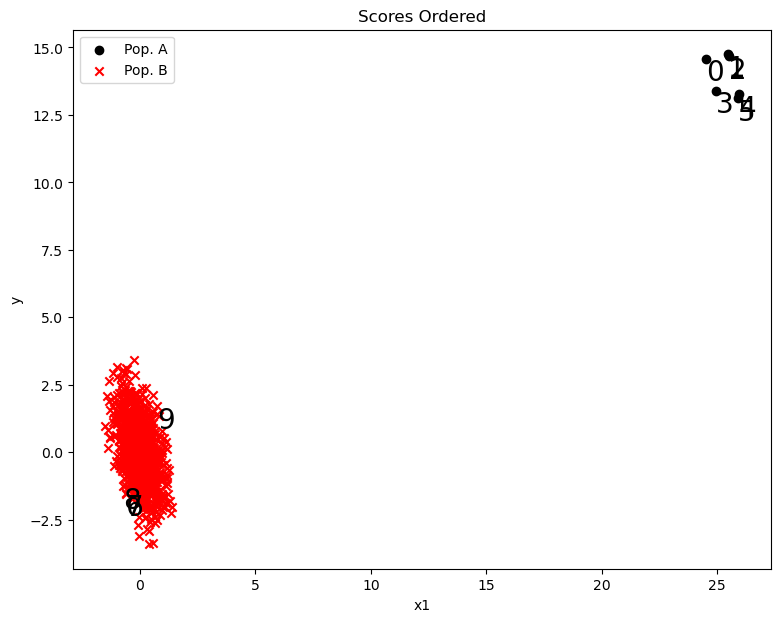

iteration 4
index to remove (original): 5
fitted beta1: 0.43440020181188577
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  1.815563  0.191239  -0.013397 -0.016565
1  25.489369  14.672190  3.540680  0.185488  -0.025730 -0.031589
2  25.933779  13.275698  1.951136  0.192003  -0.014427 -0.017855
3  25.475044  14.749208  3.623920  0.185280  -0.026320 -0.032305
4  24.924321  13.396990  2.510937  0.177367  -0.017841 -0.021687
Point to Drop:  3


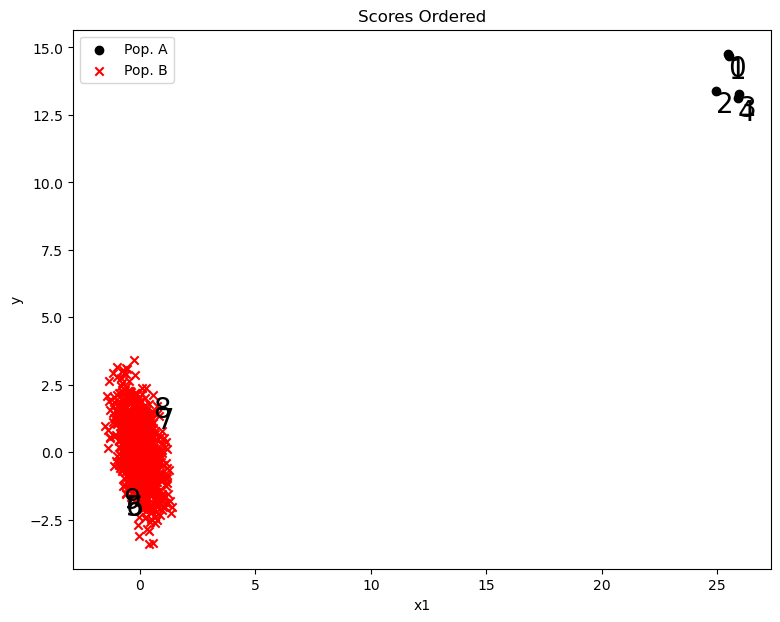

iteration 5
index to remove (original): 6
fitted beta1: 0.40209505897875497
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  2.652844  0.234729  -0.024027 -0.031397
1  25.489369  14.672190  4.365277  0.227671  -0.038936 -0.050414
2  25.933779  13.275698  2.790089  0.235668  -0.025321 -0.033129
3  24.924321  13.396990  3.317280  0.217703  -0.028930 -0.036981
4   0.072022   0.943643  0.856920  0.000996   0.000001  0.000001
Point to Drop:  1


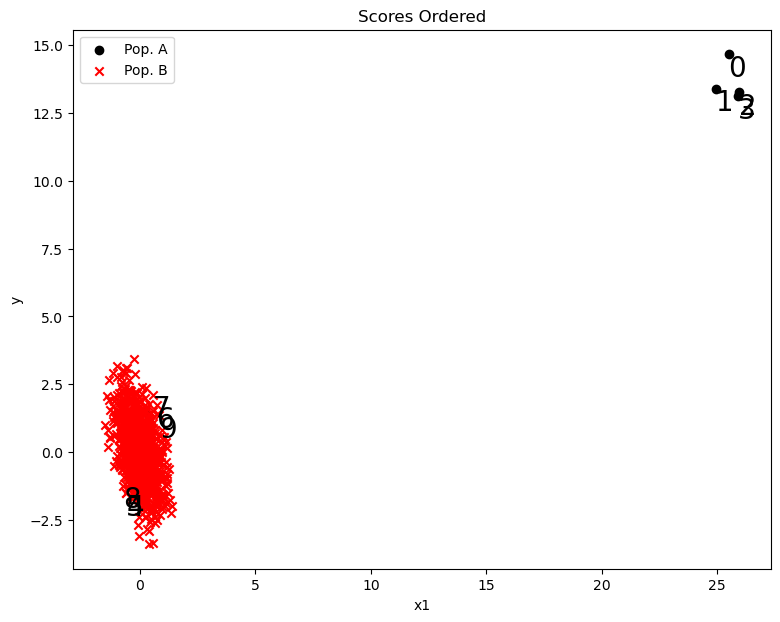

iteration 6
index to remove (original): 2
fitted beta1: 0.3516815271120153
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  3.959455  0.303924  -0.046433 -0.066706
1  25.933779  13.275698  4.099309  0.305139  -0.048169 -0.069322
2  24.924321  13.396990  4.575609  0.281878  -0.051669 -0.071950
3   0.072022   0.943643  0.862357  0.000997  -0.000008 -0.000008
4   0.727137  -0.026095 -0.337774  0.001205   0.000104  0.000104
Point to Drop:  2


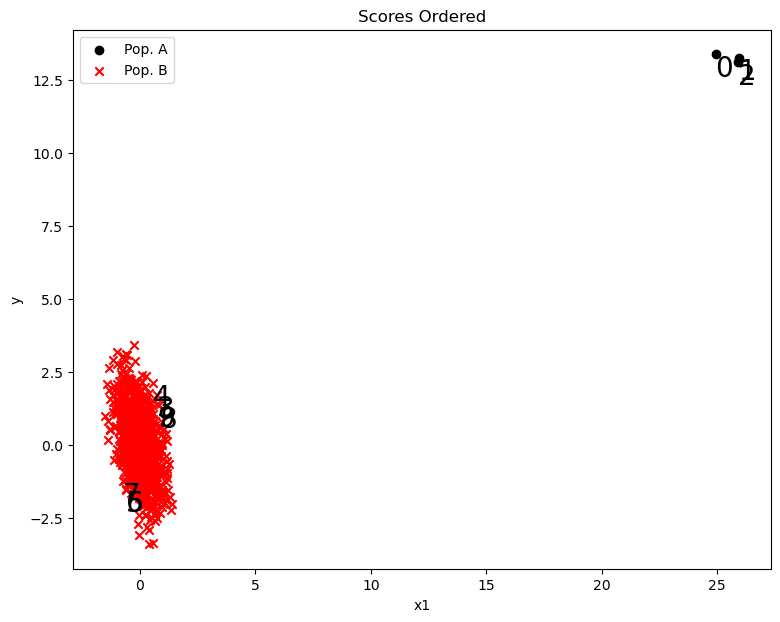

iteration 7
index to remove (original): 7
fitted beta1: 0.27973153851049654
          x1          y  residual  leverage  influence    newton
0  25.882026  13.117643  5.824385  0.423220  -0.095109 -0.164897
1  25.933779  13.275698  5.967963  0.424912  -0.097649 -0.169798
2   0.072022   0.943643  0.870257  0.000999  -0.000025 -0.000025
3   0.727137  -0.026095 -0.282738  0.001309   0.000125  0.000125
4   0.380519  -0.797996 -0.957679  0.001078   0.000215  0.000215
Point to Drop:  1


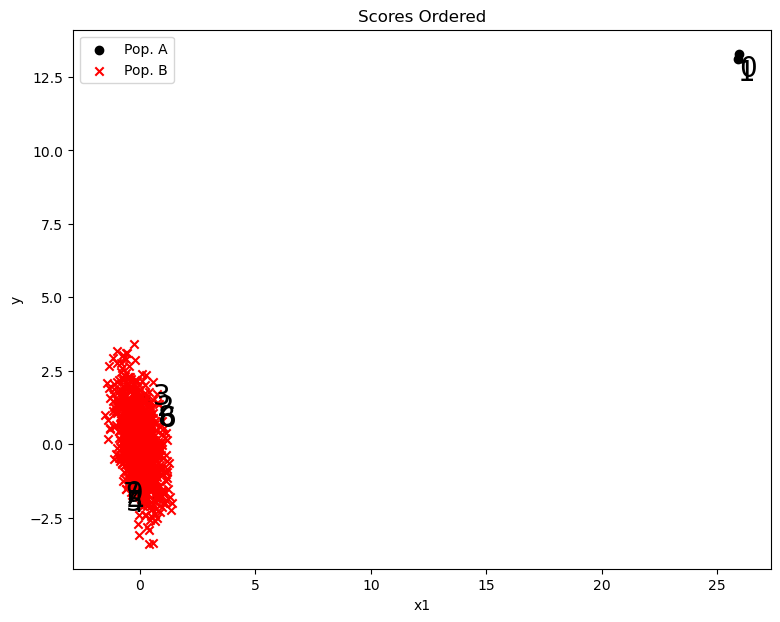

iteration 8
index to remove (original): 4
fitted beta1: 0.10993330286566791
          x1          y   residual  leverage  influence    newton
0  25.882026  13.117643  10.225103  0.735921  -0.290340 -1.099444
1   0.072022   0.943643   0.888482  0.001005  -0.000070 -0.000070
2   0.727137  -0.026095  -0.153276  0.001579   0.000122  0.000122
3   0.380519  -0.797996  -0.887071  0.001158   0.000371  0.000371
4   0.060838  -1.158334  -1.212266  0.001003   0.000081  0.000081
Point to Drop:  0


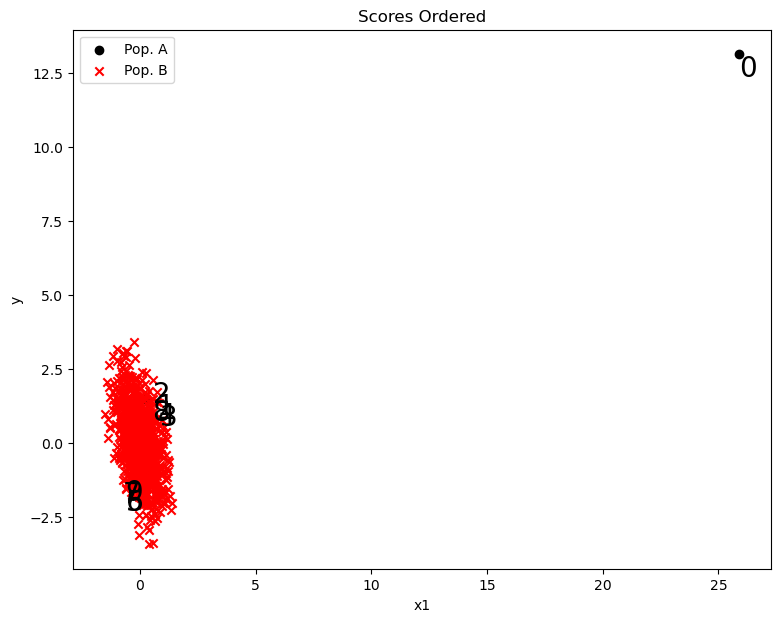

iteration 9
index to remove (original): 0
fitted beta1: -0.9895109324018502
         x1         y  residual  leverage  influence    newton
0  0.072022  0.943643  1.006567  0.001040  -0.000410 -0.000410
1  0.727137 -0.026095  0.685072  0.003355  -0.002142 -0.002149
2  0.380519 -0.797996 -0.429811  0.001686   0.000725  0.000727
3  0.060838 -1.158334 -1.106477  0.001031   0.000399  0.000400
4  0.221932  1.490374  1.701635  0.001255  -0.001752 -0.001754
Point to Drop:  927


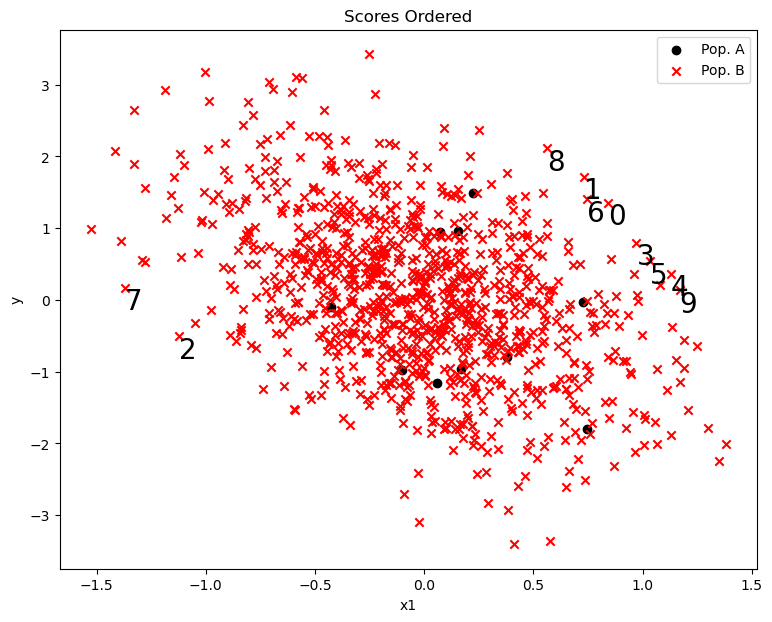

iteration 10
index to remove (original): 937
fitted beta1: -0.9973904366412818
         x1         y  residual  leverage  influence    newton
0  0.072022  0.943643  1.009530  0.001042  -0.000416 -0.000416
1  0.727137 -0.026095  0.693197  0.003368  -0.002176 -0.002184
2  0.380519 -0.797996 -0.424417  0.001692   0.000720  0.000721
3  0.060838 -1.158334 -1.103602  0.001033   0.000403  0.000404
4  0.221932  1.490374  1.705779  0.001259  -0.001767 -0.001770
Point to Drop:  388


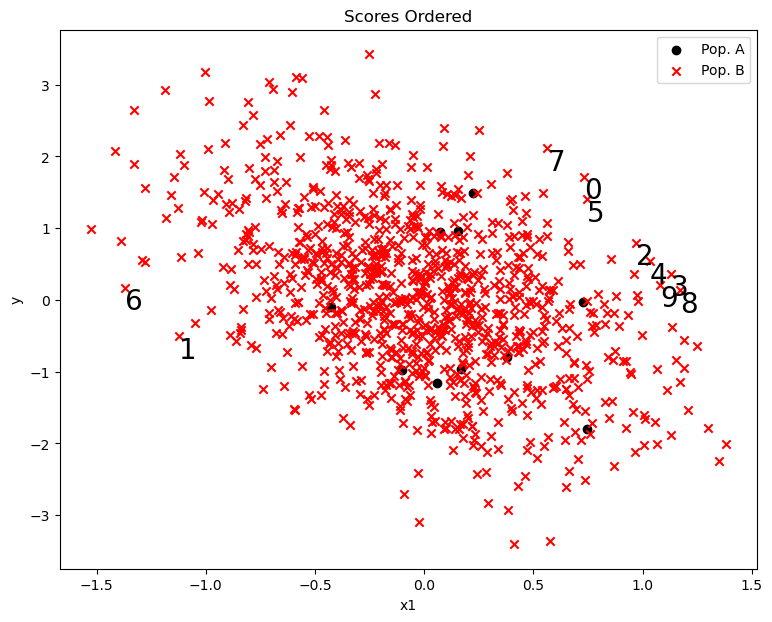

dropped order: 
 [1, 8, 3, 9, 5]
exact (greedy) beta estimates: 
 [0.5017041334413944, 0.48935079165663814, 0.47503745815665105, 0.45750814988620736, 0.43440020181188577]


In [48]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='1Exact')

print("dropped order: \n", dropped_order[:5])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:5])

In [41]:
greedy_inds = dropped_order[:10]
greedy_inds = np.array(greedy_inds)
type(greedy_inds)

numpy.ndarray

In [42]:
greedy_inds

array([1, 8, 3, 9, 5, 6, 2, 7, 4, 0])

In [43]:
greedy_inds
new_x= np.delete(orig_x, greedy_inds, axis=0)
new_y= np.delete(orig_y, greedy_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(1000, 2)
(1000,)


In [44]:
orig_x.shape

(1010, 2)

In [45]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=orig_x.T, y=orig_y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We will examine the first coefficient.

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 after removing subset: -0.9895109324018502
